<h1>Library</h1>

In [1]:
# ====================
#  IMPORTS
# ====================
import os
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import warnings
from PIL import Image
import gc
import psutil
import kornia.augmentation as K
import kornia.geometry.transform as KT

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


<h1> System Optimizations</h1>

In [2]:
# ====================
#  ADVANCED GPU OPTIMIZATIONS
# ====================
def setup_gpu_optimization():
    """Setup advanced GPU optimizations for Tesla T4"""
    
    # Enable TensorFloat-32 for faster training on Tesla T4
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    
    # Enable memory optimization
    torch.cuda.empty_cache()
    torch.cuda.memory.set_per_process_memory_fraction(0.95)  # Use 95% of GPU memory
    
    # Enable optimized attention
    torch.backends.cuda.enable_flash_sdp(True)
    
    # Set optimal number of threads
    torch.set_num_threads(min(8, psutil.cpu_count()))
    
    # CUDA optimizations
    os.environ["CUDA_LAUNCH_BLOCKING"] = "0"  # Async kernel launches
    os.environ["CUDA_CACHE_DISABLE"] = "0"
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    
    print("GPU optimizations enabled!")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"GPU {i} Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")


<h1>Device</h1>

In [3]:
# ====================
#  DEVICE SETUP WITH MULTI-GPU
# ====================
setup_gpu_optimization()

# Check for multiple GPUs
if torch.cuda.device_count() > 1:
    device = torch.device("cuda:0")  # Primary GPU
    print(f"Using {torch.cuda.device_count()} GPUs for training")
    use_multi_gpu = True
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_multi_gpu = False

print(f"Primary device: {device}")

GPU optimizations enabled!
Number of GPUs available: 2
GPU 0: Tesla T4
GPU 0 Memory: 14.74 GB
GPU 1: Tesla T4
GPU 1 Memory: 14.74 GB
Using 2 GPUs for training
Primary device: cuda:0


<h1>Hyperparameters</h1>

In [4]:
# ====================
#  OPTIMIZED CONFIGURATION
# ====================
class Config:
    def __init__(self):
        self.train_dir = "/kaggle/input/data-model2-augment-new/data_augment_new"
        self.test_dir = "/kaggle/input/logo-verify-test/logo_verify_test"
        self.input_size = 224  # Increased for better accuracy
        self.embedding_size = 512  # Increased for better feature representation
        
        # GPU-optimized batch sizes
        if torch.cuda.device_count() >= 2:
            self.batch_size = 512  # Larger batch for dual GPU
            self.num_workers = 4
        else:
            self.batch_size = 512  # Optimized for single Tesla T4
            self.num_workers = 4
            
        self.lr = 1e-3  
        self.epochs = 30
        self.margin = 0.4
        self.temperature = 0.7
        self.eval_interval = 2
        self.key = "000000"
        self.log_file = "/kaggle/working/training_log.csv"
        self.best_model_path = "/kaggle/working/best_model.pth"
        
        # Memory optimization
        self.gradient_accumulation_steps = 2
        self.max_grad_norm = 0.5
        self.warmup_steps = 1000

config = Config()

<h1>Dataset Analysis</h1>


TRAIN SET ANALYSIS
Dataset Analysis: /kaggle/input/data-model2-augment-new/data_augment_new
Number of classes: 135
Total images: 224306
Min images per class: 1280
Max images per class: 2000
Average images per class: 1661.53


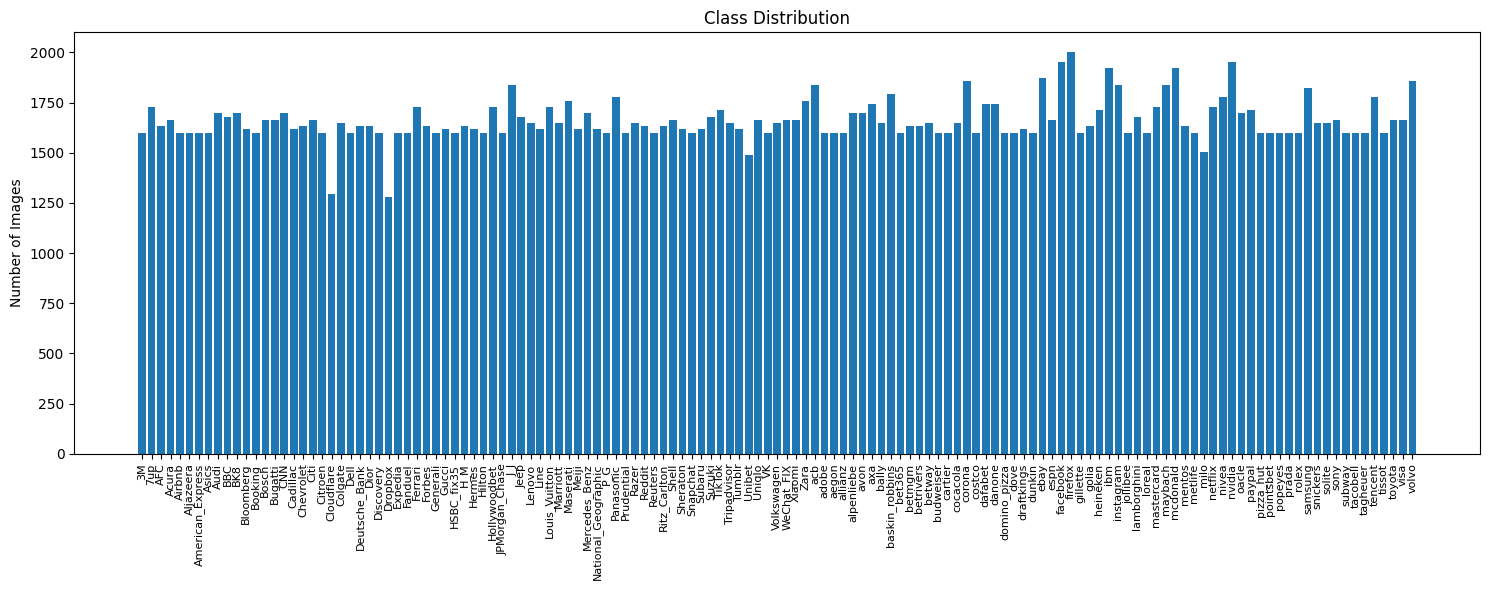


TEST SET ANALYSIS
Dataset Analysis: /kaggle/input/logo-verify-test/logo_verify_test
Number of classes: 50
Total images: 683
Min images per class: 10
Max images per class: 29
Average images per class: 13.66


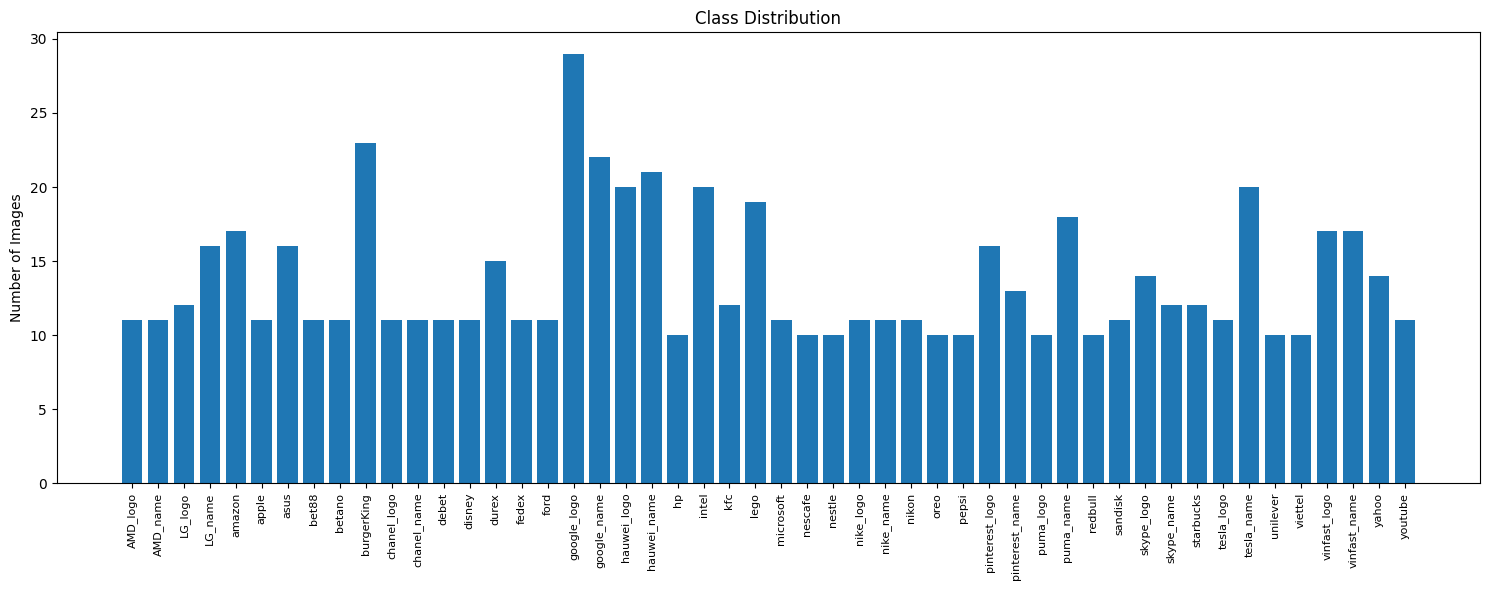

In [5]:
# ====================
#  DATASET ANALYSIS
# ====================
def analyze_dataset(directory):
    """Analyze dataset with memory optimization"""
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    num_classes = len(class_names)
    
    class_stats = {}
    total_images = 0
    min_images = float('inf')
    max_images = 0
    
    for cls in class_names:
        cls_dir = os.path.join(directory, cls)
        num_images = len([f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        class_stats[cls] = num_images
        total_images += num_images
        min_images = min(min_images, num_images)
        max_images = max(max_images, num_images)
    
    print(f"Dataset Analysis: {directory}")
    print(f"Number of classes: {num_classes}")
    print(f"Total images: {total_images}")
    print(f"Min images per class: {min_images}")
    print(f"Max images per class: {max_images}")
    print(f"Average images per class: {total_images/num_classes:.2f}")
    
    # Plot distribution
    plt.figure(figsize=(15, 6))
    plt.bar(class_stats.keys(), class_stats.values())
    plt.xticks(rotation=90, fontsize=8)
    plt.title("Class Distribution")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()
    
    return class_stats

print("\n" + "="*40)
print("TRAIN SET ANALYSIS")
print("="*40)
train_stats = analyze_dataset(config.train_dir)

print("\n" + "="*40)
print("TEST SET ANALYSIS")
print("="*40)
test_stats = analyze_dataset(config.test_dir)

<h1>Data Transform</h1>

In [6]:
# ====================
#  DATA TRANSFORMS
# ====================
def get_optimized_transforms():
    """Simple transforms without normalization as requested"""
    train_transform = A.Compose([
        A.Resize(config.input_size, config.input_size),
        A.ToFloat(max_value=255.0),
        ToTensorV2()
    ])
    
    test_transform = A.Compose([
        A.Resize(config.input_size, config.input_size),
        A.ToFloat(max_value=255.0),
        ToTensorV2()
    ])
    
    return train_transform, test_transform

<h1>Dataset & DataLoader</h1>

In [7]:
# ====================
#  OPTIMIZED DATASET
# ====================
class OptimizedLogoDataset(Dataset):
    def __init__(self, root_dir, transform, cache_size=1000):
        self.root_dir = root_dir
        self.transform = transform
        self.cache_size = cache_size
        self.image_cache = {}
        self.cache_order = []
        
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = self._load_samples()
        
        print(f"Dataset loaded: {len(self.samples)} samples, {len(self.classes)} classes")
        
    def _load_samples(self):
        samples = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            if os.path.isdir(cls_dir):
                for fname in os.listdir(cls_dir):
                    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                        samples.append((os.path.join(cls_dir, fname), self.class_to_idx[cls]))
        return samples
    
    def _load_image_cached(self, path):
        if path in self.image_cache:
            return self.image_cache[path]
        
        # Load image
        img = cv2.imread(path)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Cache management
        if len(self.image_cache) >= self.cache_size:
            oldest_path = self.cache_order.pop(0)
            del self.image_cache[oldest_path]
        
        self.image_cache[path] = img
        self.cache_order.append(path)
        
        return img
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = self._load_image_cached(path)
            augmented = self.transform(image=img)
            return augmented["image"], label
        except Exception as e:
            print(f"Error loading {path}: {str(e)}")
            return torch.zeros(3, config.input_size, config.input_size), 0

<h1>Backbone</h1>

<h2>EfficientNet</h2>

In [8]:
# ====================
#  OPTIMIZED BACKBONE
# ====================
class OptimizedEfficientNet(nn.Module):
    """Optimized EfficientNet for Tesla T4"""
    def __init__(self, embedding_size=512):
        super().__init__()
        # Use EfficientNet-B2 for better accuracy without too much overhead
        self.backbone = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        
        # Optimized head
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features, embedding_size * 2),
            nn.BatchNorm1d(embedding_size * 2),
            nn.SiLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(embedding_size * 2, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        features = self.backbone(x)
        return F.normalize(features, p=2, dim=1)

<h2>RESNET</h2>

In [9]:
# ====================
#  OPTIMIZED BACKBONE
# ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class OptimizedResNet18(nn.Module):
    def __init__(self, embedding_size=512, num_classes=1000):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_feat = backbone.fc.in_features
        backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, embedding_size * 2),
            nn.BatchNorm1d(embedding_size * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(embedding_size * 2, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )
        self.backbone = backbone
        self.classifier = nn.Linear(embedding_size, num_classes)
        for m in self.backbone.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        nn.init.kaiming_normal_(self.classifier.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(self.classifier.bias)
        
    def forward(self, x):
        emb = self.backbone(x)
        emb = F.normalize(emb, p=2, dim=1)
        logits = self.classifier(emb)
        return emb, logits

<h1>Loss Function</h1>

<h2>SUP-Contrastive Loss</h2>

In [10]:
# ====================
#  ADVANCED LOSS FUNCTIONS
# ====================
_EPS = 1e-8

class SupervisedContrastiveLoss(nn.Module):
    """
    Supervised Contrastive Loss (Khosla et al., 2020) with numerical stability.
    Encourages embeddings of samples with the same label to be close.
    """
    def __init__(self, temperature: float = 0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        features: Tensor of shape [batch_size, feature_dim], assumed not yet normalized
        labels:   LongTensor of shape [batch_size]
        """
        device = features.device
        batch_size = features.size(0)

        # 1) Normalize features to unit hypersphere
        features = F.normalize(features, p=2, dim=1)

        # 2) Compute similarity matrix
        #    sim_matrix[i,j] = dot(features[i], features[j]) / temperature
        sim_matrix = torch.div(
            torch.matmul(features, features.T),
            self.temperature
        )

        # 3) Build mask of positives (same label), exclude self-comparisons
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        # Zero out diagonal
        mask = mask - torch.eye(batch_size, device=device)

        # 4) Compute log-probabilities with softmax
        log_prob = F.log_softmax(sim_matrix, dim=1)

        # 5) For each sample, average the log-prob over its positive pairs
        #    If a sample has no positive (mask.sum==0), we clamp denominator to 1 to avoid NaN.
        positives_per_row = mask.sum(1)
        mean_log_prob_pos = (mask * log_prob).sum(1) / (positives_per_row + _EPS)

        # 6) Loss is the negative of the average log-prob over all samples
        loss = -mean_log_prob_pos.mean()
        return loss


<h2>Focal</h2>

In [11]:
# ====================
#  ADVANCED LOSS FUNCTIONS
# ====================
class FocalLoss(nn.Module):
    """
    Focal Loss for multi-class classification (Lin et al., 2017).
    Applied on raw classifier logits.
    """
    def __init__(self, alpha: float = 1.0, gamma: float = 2.0, reduction: str = 'mean'):
        """
        alpha:    balancing factor (default 1.0)
        gamma:    focusing parameter (default 2.0)
        reduction:'mean' | 'sum' | 'none'
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        logits: Tensor of shape [batch_size, num_classes]
        labels: LongTensor of shape [batch_size]
        """
        # 1) Compute per-sample cross-entropy without reduction
        ce_loss = F.cross_entropy(logits, labels, reduction='none')

        # 2) Compute probability of the true class
        p_t = torch.exp(-ce_loss)

        # 3) Compute focal factor
        focal_factor = (1 - p_t) ** self.gamma

        # 4) Combine
        loss = self.alpha * focal_factor * ce_loss

        # 5) Reduction
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

<h2>Combine Loss</h2>

In [12]:
# ====================
#  ADVANCED LOSS FUNCTIONS
# ====================
class CombinedAdvancedLoss(nn.Module):
    def __init__(self, temperature=0.5, alpha=0.7, gamma=2):
        super().__init__()
        self.scl   = SupervisedContrastiveLoss(temperature)
        self.focal = FocalLoss(alpha=1.0, gamma=gamma)
        self.alpha = alpha
    def forward(self, features, logits, labels):
        # normalize + clamp embeddings
        features = F.normalize(features, p=2, dim=1)
        features = torch.clamp(features, -0.999, 0.999)
        # clamp logits to avoid extreme values
        logits = torch.clamp(logits, -10.0, 10.0)
        loss_scl   = self.scl(features, labels)
        loss_focal = self.focal(logits,   labels)
        return self.alpha * loss_scl + (1 - self.alpha) * loss_focal

<h1>Test Function</h1>

In [13]:
# ====================
#  OPTIMIZED TEST FUNCTION
# ====================
def optimized_test(folder_path, model, transforms, key, batch_size=64):
    """Highly optimized test function with GPU batching"""
    
    model.eval()
    
    # Collect all data first
    reference_data = []
    test_data = []
    label_map = {}
    
    with torch.no_grad():
        for label_idx, subfolder in enumerate(sorted(os.listdir(folder_path))):
            subfolder_path = os.path.join(folder_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue
                
            label_map[label_idx] = subfolder
            
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                
                if key in image_path:
                    reference_data.append((image_path, label_idx))
                else:
                    test_data.append((image_path, label_idx))
        
        # Process reference images in batches
        reference_embeddings = []
        reference_labels     = []
        
        for i in range(0, len(reference_data), batch_size):
            batch = reference_data[i:i+batch_size]
            imgs, lbls = [], []
            for img_path, label in batch:
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = transforms(image=np.array(img))["image"]
                    imgs.append(img)
                    lbls.append(label)
                except:
                    continue
            
            if not imgs:
                continue
            
            batch_tensor = torch.stack(imgs).to(device)
            features, _  = model(batch_tensor)          # ← unpack tuple
            reference_embeddings.extend(features.cpu())
            reference_labels.extend(lbls)
        
        reference_embeddings = torch.stack(reference_embeddings).to(device)
        reference_labels     = torch.tensor(reference_labels).to(device)
        
        # Process test images in batches
        predictions      = []
        true_labels      = []
        max_similarities = []
        
        for i in range(0, len(test_data), batch_size):
            batch = test_data[i:i+batch_size]
            imgs, lbls = [], []
            for img_path, label in batch:
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = transforms(image=np.array(img))["image"]
                    imgs.append(img)
                    lbls.append(label)
                except:
                    continue
            
            if not imgs:
                continue
            
            batch_tensor = torch.stack(imgs).to(device)
            test_features, _ = model(batch_tensor)      # ← unpack tuple
            
            # Compute cosine similarities
            similarities = torch.matmul(test_features, reference_embeddings.t())
            max_vals, max_idxs = similarities.max(dim=1)
            
            pred_labels = reference_labels[max_idxs]
            
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(lbls)
            max_similarities.extend(max_vals.cpu().numpy())
        
        accuracy = accuracy_score(true_labels, predictions)
        print(f'Accuracy: {accuracy:.4f}')
        
        return accuracy, predictions, true_labels, max_similarities


<h1>Optimized</h1>

In [14]:
# ====================
#  OPTIMIZED TRAINING SETUP
# ====================
def setup_optimized_training():
    """Setup optimized training with multi-GPU support"""

    # Enable cuDNN autotuner for fixed-size inputs
    torch.backends.cudnn.benchmark = True

    # Advanced learning rate scheduler
    train_t, _   = get_optimized_transforms()
    train_dataset = OptimizedLogoDataset(config.train_dir, train_t)
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=4
    )

    num_classes = len(train_dataset.classes)
    
    # Choose the best model for Tesla T4
    model = OptimizedResNet18(embedding_size=config.embedding_size,num_classes=num_classes)
    model = model.to(device)

    # Multi-GPU setup
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print(f"Model wrapped with DataParallel for {torch.cuda.device_count()} GPUs")

    
    # Advanced loss function
    criterion = CombinedAdvancedLoss(
        temperature=config.temperature,
        alpha=0.7,
        gamma=2
    )
    
    # Optimized optimizer with weight decay
    optimizer = AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        # model.parameters(),
        lr=config.lr,
        weight_decay=0.01
    )
    
    # Cosine annealing with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=len(train_loader) * 5,  # Restart every 10 epochs
        T_mult=1,
        eta_min=1e-6
    )
    
    return model, criterion, optimizer, scheduler, train_loader

<h1>Training Loop</h1>

In [15]:
import os
import csv
import torch
import gc
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# ====================
#  OPTIMIZED TRAINING LOOP
# ====================
def train_optimized_model():
    """Optimized training function with all improvements"""
    model, criterion, optimizer, scheduler, train_loader = setup_optimized_training()
    _, test_transform = get_optimized_transforms()

    
    scaler = torch.cuda.amp.GradScaler()
    best_acc = 0.0
    patience = 10
    pat_ctr = 0
    train_losses, accuracies = [], []

    # CSV logging
    fh = open(config.log_file, 'a', newline='')
    writer = csv.writer(fh)
    if os.stat(config.log_file).st_size == 0:
        writer.writerow(['epoch','train_loss','accuracy'])
    
    print("Starting optimized training...")
    for epoch in range(config.epochs):
        model.train()
        ep_loss = 0.0
        nb = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs}")
        
        for i, (imgs, lbls) in enumerate(pbar):
            #  Move batch to GPU
            imgs = imgs.to(device, non_blocking=True)
            lbls = lbls.to(device, non_blocking=True)
            
             #  Forward + loss
            with torch.cuda.amp.autocast():
                features, logits = model(imgs)
                loss = criterion(features, logits, lbls)
                loss = loss / config.gradient_accumulation_steps
                if torch.isnan(loss):
                    print(f"⚠️ NaN loss at batch {i}, skipping")
                    optimizer.zero_grad(set_to_none=True)
                    continue

            # Backward + step
            scaler.scale(loss).backward()
            if (i+1) % config.gradient_accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                scheduler.step()
                
            ep_loss += loss.item() * config.gradient_accumulation_steps
            nb += 1
            pbar.set_postfix({
                'Loss':f'{loss.item()*config.gradient_accumulation_steps:.4f}',
                'LR':f'{scheduler.get_last_lr()[0]:.1e}'
            })
            
        avg_loss = ep_loss/nb
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1} — Training Loss: {avg_loss:.4f}")
        
        acc = None
        if (epoch+1) % config.eval_interval == 0:
            print(f"\nEvaluating epoch {epoch+1}...")
            acc, _, _, _ = optimized_test(
                config.test_dir,
                model,
                test_transform,
                config.key,
                batch_size=config.batch_size
            )
            accuracies.append(acc)
            print(f"→ Validation Accuracy: {acc:.4f}")
            
            if acc > best_acc:
                best_acc = acc
                pat_ctr = 0
                torch.save(model.state_dict(), config.best_model_path)
                print("New best model saved!")
            else:
                pat_ctr += 1
                if pat_ctr >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
                    
        writer.writerow([
            epoch+1, f"{avg_loss:.4f}",
            f"{acc:.4f}" if acc is not None else ""
        ])
        fh.flush()
        
    fh.close()
    print(f"Training done! Best accuracy: {best_acc:.4f}")
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses); plt.title('Train Loss'); plt.xlabel('Epoch')
    plt.subplot(1,2,2)
    plt.plot(range(config.eval_interval, len(accuracies)*config.eval_interval+1, config.eval_interval), accuracies)
    plt.title('Val Acc'); plt.xlabel('Epoch')
    plt.tight_layout(); plt.show()
    return model

<h1>MAIN</h1>


STARTING OPTIMIZED TRAINING
Dataset loaded: 224306 samples, 135 classes
Model wrapped with DataParallel for 2 GPUs
Starting optimized training...


/tmp/ipykernel_1013/3161198266.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 — Training Loss: 4.1366


Epoch 2/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 2 — Training Loss: 3.4178

Evaluating epoch 2...
Accuracy: 0.5577
→ Validation Accuracy: 0.5577
New best model saved!


Epoch 3/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 — Training Loss: 3.3594


Epoch 4/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 4 — Training Loss: 3.3457

Evaluating epoch 4...
Accuracy: 0.4787
→ Validation Accuracy: 0.4787


Epoch 5/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 — Training Loss: 3.3382


Epoch 6/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 6 — Training Loss: 3.3351

Evaluating epoch 6...
Accuracy: 0.3728
→ Validation Accuracy: 0.3728


Epoch 7/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 — Training Loss: 3.3324


Epoch 8/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 8 — Training Loss: 3.3307

Evaluating epoch 8...
Accuracy: 0.3523
→ Validation Accuracy: 0.3523


Epoch 9/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 — Training Loss: 3.3306


Epoch 10/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 10 — Training Loss: 3.3289

Evaluating epoch 10...
Accuracy: 0.3365
→ Validation Accuracy: 0.3365


Epoch 11/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11 — Training Loss: 3.3604


Epoch 12/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 12 — Training Loss: 3.3564

Evaluating epoch 12...
Accuracy: 0.5324
→ Validation Accuracy: 0.5324


Epoch 13/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13 — Training Loss: 3.3331


Epoch 14/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 14 — Training Loss: 3.3263

Evaluating epoch 14...
Accuracy: 0.4376
→ Validation Accuracy: 0.4376


Epoch 15/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15 — Training Loss: 3.3218


Epoch 16/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 16 — Training Loss: 3.3233

Evaluating epoch 16...
Accuracy: 0.3807
→ Validation Accuracy: 0.3807


Epoch 17/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17 — Training Loss: 3.3219


Epoch 18/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 18 — Training Loss: 3.3221

Evaluating epoch 18...
Accuracy: 0.3381
→ Validation Accuracy: 0.3381


Epoch 19/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19 — Training Loss: 3.3211


Epoch 20/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 20 — Training Loss: 3.3212

Evaluating epoch 20...
Accuracy: 0.3649
→ Validation Accuracy: 0.3649


Epoch 21/30:   0%|          | 0/439 [00:00<?, ?it/s]

/tmp/ipykernel_1013/3161198266.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21 — Training Loss: 3.3341


Epoch 22/30:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 22 — Training Loss: 3.3430

Evaluating epoch 22...
Accuracy: 0.4234
→ Validation Accuracy: 0.4234
Early stopping at epoch 22
Training done! Best accuracy: 0.5577


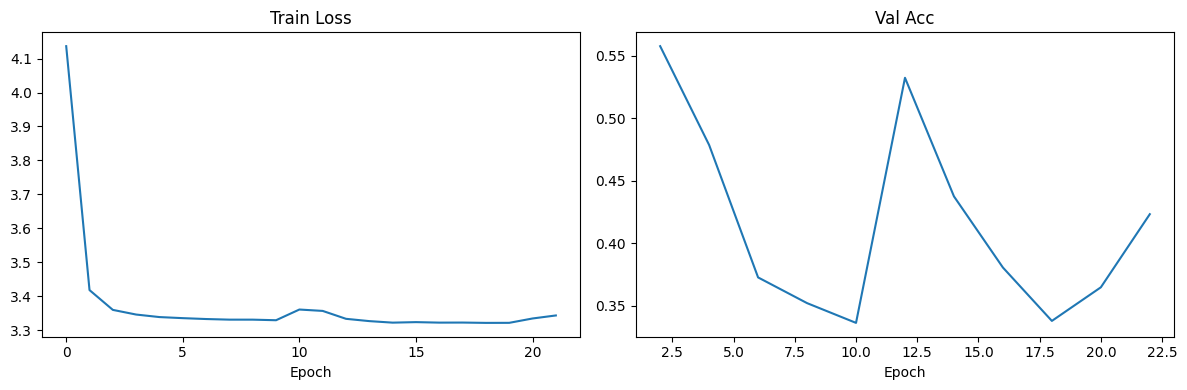


FINAL EVALUATION
Accuracy: 0.4234
Final Test Accuracy: 0.4234


In [16]:
# ====================
#  MAIN EXECUTION
# ====================
if __name__ == "__main__":
    # Train the model
    print("\n" + "="*50)
    print("STARTING OPTIMIZED TRAINING")
    print("="*50)
    trained_model = train_optimized_model()
    
    # Final evaluation
    print("\n" + "="*50)
    print("FINAL EVALUATION")
    print("="*50)
    test_transform = get_optimized_transforms()[1]
    final_accuracy, predictions, true_labels, similarities = optimized_test(
        config.test_dir, 
        trained_model, 
        test_transform, 
        config.key,
        batch_size=config.batch_size
    )
    
    print(f"Final Test Accuracy: {final_accuracy:.4f}")